In [1]:
import tensorflow as tf
from utils import *
%matplotlib inline
import matplotlib.pyplot as plt
slim = tf.contrib.slim

In [2]:
image_height = 28
image_weight = 28
channels = 1
batch_size = 64
z_dim = 128
lr = 0.0001
num_epochs = 20
X_images = tf.placeholder(tf.float32, shape=[batch_size, image_height, image_weight, channels])
noise_z = tf.placeholder(tf.float32, shape=[batch_size, z_dim])
dataset_name = 'fashion-mnist'

In [3]:
images, _ = load_mnist(dataset_name)
num_batches = len(images) // batch_size

In [4]:
def generator(z, reuse):
    repeat_time = 2
    channel = 128
    with tf.variable_scope("G", reuse=reuse) as vs:
        x = slim.fully_connected(z, 7*7*z_dim, activation_fn=None)
        x = tf.reshape(x, [-1, 7, 7, z_dim])
        for i in range(repeat_time):
            x = slim.conv2d(x, channel, 3, 1, activation_fn=tf.nn.elu)
            x = slim.conv2d(x, channel, 3, 1, activation_fn=tf.nn.elu)
            x = slim.conv2d_transpose(x, channel, [3, 3], [2, 2])
        output_image = slim.conv2d(x, 1, 3, 1, activation_fn=None)
    variables = tf.contrib.framework.get_variables(vs)
    return output_image, variables

In [5]:
def discriminator(x):
    repeat_time = 3
    channel = 128
    with tf.variable_scope("D") as vs:
        for i in range(repeat_time):
            x = slim.conv2d(x, channel, 3, 1, activation_fn=tf.nn.elu)
            x = slim.conv2d(x, channel, 3, 1, activation_fn=tf.nn.elu)
            if i < repeat_time - 1:
                x = slim.conv2d(x, channel, 3, 2, activation_fn=tf.nn.elu)
        x = tf.reshape(x, [-1, 7*7*128])
        logit = slim.fully_connected(x, 1, activation_fn=None)
        prob = tf.nn.sigmoid(logit)
        variables = tf.contrib.framework.get_variables(vs)
        return prob, logit, variables

In [6]:
def build_model():
    G_sample, G_var = generator(noise_z, reuse=False)
    fake_images, _ = generator(noise_z, reuse=True)
    _, D_logit, D_var= discriminator(tf.concat([G_sample, X_images], 0))
    D_logit_fake, D_logit_real = tf.split(D_logit, 2)
    D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
    D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
    D_loss = D_loss_real + D_loss_fake
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
    D_solver = tf.train.AdamOptimizer(lr).minimize(D_loss, var_list=D_var)
    G_solver = tf.train.AdamOptimizer(lr).minimize(G_loss, var_list=G_var)
    return D_solver, G_solver, D_loss, G_loss, fake_images

In [7]:
D_solver, G_solver, D_loss, G_loss, fake_images = build_model()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
counter = 0
g_loss_history = []
d_loss_history = []
for epoch in range(0, num_epochs):
    for idx in range(0, num_batches):
        batch_images = images[idx*batch_size:(idx+1)*batch_size]
        noise = np.random.uniform(-1., 1., size=[batch_size, z_dim])
        _, d_loss = sess.run([D_solver, D_loss], feed_dict={X_images: batch_images, noise_z: noise})
        _, g_loss = sess.run([G_solver, G_loss], feed_dict={X_images: batch_images, noise_z: noise})
        g_loss_history.append(g_loss)
        d_loss_history.append(d_loss)
        counter += 1
        if np.mod(idx, 800) == 0:
            print("Epoch: [%2d] [%4d/%4d] d_loss: %.8f, g_loss: %.8f" % (epoch, idx, num_batches, d_loss, g_loss))
        # save training results for every 1000 steps
        if np.mod(counter, 1000) == 0:
            samples = sess.run(fake_images, feed_dict={noise_z: noise})
            manifold_h = int(np.floor(np.sqrt(batch_size)))
            manifold_w = int(np.floor(np.sqrt(batch_size)))
            save_images(samples[:manifold_h * manifold_w, :, :, :], [manifold_h, manifold_w],
                        './results/Vanilla_GAN_Images/'+str(epoch)+'_'+str(idx)+'.png')

Epoch: [ 0] [   0/1093] d_loss: 1.39844036, g_loss: 0.69641685
Epoch: [ 0] [ 800/1093] d_loss: 2.41087151, g_loss: 1.72046113
Epoch: [ 1] [   0/1093] d_loss: 3.78137469, g_loss: 1.09098673
Epoch: [ 1] [ 800/1093] d_loss: 0.74484754, g_loss: 2.19498754
Epoch: [ 2] [   0/1093] d_loss: 0.53854728, g_loss: 3.79732418
Epoch: [ 2] [ 800/1093] d_loss: 0.44988066, g_loss: 2.44287539
Epoch: [ 3] [   0/1093] d_loss: 0.64357638, g_loss: 2.99442577
Epoch: [ 3] [ 800/1093] d_loss: 0.43899322, g_loss: 2.68631077
Epoch: [ 4] [   0/1093] d_loss: 0.58883405, g_loss: 2.92850399
Epoch: [ 4] [ 800/1093] d_loss: 0.47825223, g_loss: 3.77296209
Epoch: [ 5] [   0/1093] d_loss: 0.57612932, g_loss: 2.37538147
Epoch: [ 5] [ 800/1093] d_loss: 0.29628956, g_loss: 2.70098472
Epoch: [ 6] [   0/1093] d_loss: 0.80401433, g_loss: 2.98747897
Epoch: [ 6] [ 800/1093] d_loss: 0.32920864, g_loss: 3.13400602
Epoch: [ 7] [   0/1093] d_loss: 0.57979226, g_loss: 2.64192414
Epoch: [ 7] [ 800/1093] d_loss: 0.36426809, g_loss: 2.9

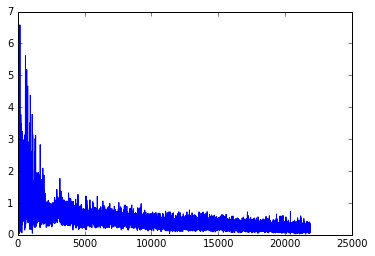

In [8]:
plt.plot(d_loss_history)

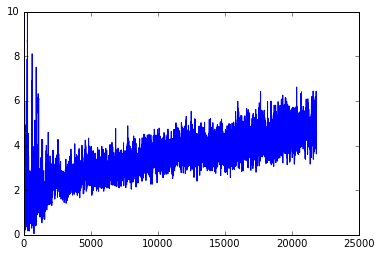

In [9]:
plt.plot(g_loss_history)